In [1073]:
# importing libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



## Scraping data

We will use the Electric Vehicle Database (https://ev-database.org) to collect the data under their **Free Use** data policy.

In [1074]:
# Request to website and download HTML contents
url='https://ev-database.org/#sort:path~type~order=.price~number~desc|range-slider-range:prev~next=0~1200|range-slider-acceleration:prev~next=2~23|range-slider-topspeed:prev~next=110~450|range-slider-battery:prev~next=10~200|range-slider-towweight:prev~next=0~2500|range-slider-fastcharge:prev~next=0~1500|paging:currentPage=0|paging:number=all'
req=requests.get(url)
content=req.text
soup = BeautifulSoup(content)

In [1075]:
# car brand

html_tags = soup.find_all('h2')
brand = []
for tags in html_tags:
    brand.append(tags.text.split(' ')[0])

In [1076]:
# car model

html_models = soup.find_all('span', class_='model')
model = []
for mod in html_models:
    model.append(mod.text)

In [1077]:
# car specs

html_specs = soup.find_all('div', class_='specs')
acceleration = []
top_speed = []
total_range = []
efficiency = []
fast_charge = []
for specs in html_specs:
    acceleration.append(specs.contents[1].contents[3].text)
    top_speed.append(specs.contents[3].contents[3].text)
    total_range.append(specs.contents[5].contents[3].text)
    efficiency.append(specs.contents[7].contents[3].text)
    fast_charge.append(specs.contents[9].contents[3].text)

In [1078]:
# car prices

html_pricing = soup.find_all('div', class_='pricing align-right')
price_germany = []
price_netherlands = []
price_uk = []
for price in html_pricing:
    price_germany.append(price.contents[1].contents[1].text)
    price_netherlands.append(price.contents[3].contents[1].text)
    price_uk.append(price.contents[5].contents[1].text)

In [1079]:
# car battery capacity

html_battery = soup.find_all('span', class_ = 'battery')
battery_cap = []
for battery in html_battery:
    battery_cap.append(battery.text)

In [1080]:
# number of seats

html_seats = soup.find_all('span', title = 'Number of seats') # contains 2 entries for each vehicle with the second one giving the seats
seats = []
for ind in range(1, 490, 2): # collecting only odd entries
    seats.append(html_seats[ind].text)

In [1081]:
# car market segment

html_ms = soup.find_all('span', title = 'Market Segment')
market_segment = []
for entry in html_ms:
    market_segment.append(entry.text)

In [1082]:
# car drive, shape and plug type

html_icons = soup.find_all('div', class_='icons')
drive = []
plug_type = []
shape = []
for entry in html_icons:
    drive.append(entry.contents[-7].get('title')) # parsing from below as towbar has varying options
    plug_type.append(entry.contents[-6].text)
    shape.append(entry.contents[-5].text)

In [1083]:
# combining all the scraped data into a dataframe

ev_df = pd.DataFrame({'brand':brand, 'model':model, 'drive':drive, 'shape':shape, 'plug_type':plug_type, 'battery_cap':battery_cap, 'seats':seats, 'drive':drive, 'market_segment':market_segment, 'acceleration':acceleration, 'top_speed':top_speed, 'total_range':total_range, 'efficiency':efficiency, 'fast_charge':fast_charge, 'price_germany':price_germany, 'price_netherlands':price_netherlands, 'price_uk':price_uk})

In [1084]:
ev_df.head()

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
0,Honda,e,Rear Wheel Drive,Hatchback,Type 2 CCS,28.5,4,B,9.0 sec,145 km/h,170 km,168 Wh/km,190 km/h,"€33,850",N/A,N/A
1,Tesla,Model 3 Long Range Dual Motor,All Wheel Drive,Sedan,Type 2 CCS,75,5,D,4.4 sec,233 km/h,485 km,155 Wh/km,750 km/h,"€65,365","€60,995","£57,490"
2,Tesla,Model 3,Rear Wheel Drive,Sedan,Type 2 CCS,57.5,5,D,6.1 sec,225 km/h,380 km,151 Wh/km,630 km/h,"€55,865","€52,995","£48,490"
3,Tesla,Model Y Long Range Dual Motor,All Wheel Drive,SUV,Type 2 CCS,75,5,D,5.0 sec,217 km/h,435 km,172 Wh/km,670 km/h,"€62,165","€66,995","£57,990"
4,BMW,i4 eDrive40,Rear Wheel Drive,Sedan,Type 2 CCS,80.7,5,D,5.7 sec,190 km/h,470 km,172 Wh/km,650 km/h,"€59,200","€60,630","£53,480"


In [1085]:
# using different webpages to scrape data


# html_url_list = soup.find_all('h2')
# url_list = []
# for url in html_url_list:
#     url_list.append('https://ev-database.org' + url.a.get('href'))
# test_url = url_list[0]
# req=requests.get(test_url)
# content=req.text
# test_soup = BeautifulSoup(content)

# tables = test_soup.find_all('table')
# tables[5].contents[-2].contents[3].text
# drive = []
# for url in url_list:
#     req=requests.get(url)
#     content=req.text
#     test_soup = BeautifulSoup(content)
#     tables = test_soup.find_all('table')
#     drive.append(tables[5].contents[-2].contents[3].text)

## Cleaning the data

In [1086]:
# remove units like km/h, sec etc.

def remove_units(df, col):
    df[col] = df[col].str.split(' ').str[0]


cols_with_units = ['acceleration', 'top_speed', 'total_range', 'efficiency', 'fast_charge']
for col in cols_with_units:
    remove_units(ev_df, col)

In [1087]:
ev_df.head()

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
0,Honda,e,Rear Wheel Drive,Hatchback,Type 2 CCS,28.5,4,B,9.0,145,170,168,190,"€33,850",N/A,N/A
1,Tesla,Model 3 Long Range Dual Motor,All Wheel Drive,Sedan,Type 2 CCS,75,5,D,4.4,233,485,155,750,"€65,365","€60,995","£57,490"
2,Tesla,Model 3,Rear Wheel Drive,Sedan,Type 2 CCS,57.5,5,D,6.1,225,380,151,630,"€55,865","€52,995","£48,490"
3,Tesla,Model Y Long Range Dual Motor,All Wheel Drive,SUV,Type 2 CCS,75,5,D,5.0,217,435,172,670,"€62,165","€66,995","£57,990"
4,BMW,i4 eDrive40,Rear Wheel Drive,Sedan,Type 2 CCS,80.7,5,D,5.7,190,470,172,650,"€59,200","€60,630","£53,480"


The prices have currencies attached to them and some of them are starred. We need to remove these characters to get a numeric value.

In [1088]:
# using regex filter to get numeric values
def clean_currency(df, col):
    df[col] = df[col].str.replace('[^0-9_]', '', regex=True)

# replace N/A with null values
ev_df = ev_df.replace('N/A', np.nan)

cols_with_prices = ['price_germany', 'price_netherlands', 'price_uk']
for col in cols_with_prices:
    clean_currency(ev_df, col)

In [1089]:
ev_df.head()

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
0,Honda,e,Rear Wheel Drive,Hatchback,Type 2 CCS,28.5,4,B,9.0,145,170,168,190,33850,NaN,NaN
1,Tesla,Model 3 Long Range Dual Motor,All Wheel Drive,Sedan,Type 2 CCS,75,5,D,4.4,233,485,155,750,65365,60995,57490
2,Tesla,Model 3,Rear Wheel Drive,Sedan,Type 2 CCS,57.5,5,D,6.1,225,380,151,630,55865,52995,48490
3,Tesla,Model Y Long Range Dual Motor,All Wheel Drive,SUV,Type 2 CCS,75,5,D,5.0,217,435,172,670,62165,66995,57990
4,BMW,i4 eDrive40,Rear Wheel Drive,Sedan,Type 2 CCS,80.7,5,D,5.7,190,470,172,650,59200,60630,53480


Some of the values in the fast_charge column are not available.

In [1090]:
ev_df[ev_df['fast_charge'].str.isnumeric() == False]

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
85,Renault,Twingo Electric,Rear Wheel Drive,Hatchback,Type 2,21.3,4,A,12.6,135,130,164,-,28000,23020,NaN
133,Smart,EQ fortwo coupe,Rear Wheel Drive,Hatchback,Type 2,16.7,2,A,11.6,130,100,167,-,21940,24879,22225
180,Smart,EQ fortwo cabrio,Rear Wheel Drive,Cabrio,Type 2,16.7,2,A,11.9,130,95,176,-,25200,27904,24645


In [1091]:
# replace unavailable values to null
ev_df = ev_df.replace({'-':np.nan})

In [1092]:
# converting numerical strings to integers/floats

def convert_to_float(df, col):
    df[col] = df[col].astype(float)

numerical_cols = ['battery_cap','seats', 'acceleration', 'top_speed', 'total_range', 'efficiency', 'fast_charge', 'price_germany', 'price_netherlands', 'price_uk']
for col in numerical_cols:
    convert_to_float(ev_df, col)


In [1093]:
ev_df.head()

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
0,Honda,e,Rear Wheel Drive,Hatchback,Type 2 CCS,28.5,4.0,B,9.0,145.0,170.0,168.0,190.0,33850.0,NaN,NaN
1,Tesla,Model 3 Long Range Dual Motor,All Wheel Drive,Sedan,Type 2 CCS,75.0,5.0,D,4.4,233.0,485.0,155.0,750.0,65365.0,60995.0,57490.0
2,Tesla,Model 3,Rear Wheel Drive,Sedan,Type 2 CCS,57.5,5.0,D,6.1,225.0,380.0,151.0,630.0,55865.0,52995.0,48490.0
3,Tesla,Model Y Long Range Dual Motor,All Wheel Drive,SUV,Type 2 CCS,75.0,5.0,D,5.0,217.0,435.0,172.0,670.0,62165.0,66995.0,57990.0
4,BMW,i4 eDrive40,Rear Wheel Drive,Sedan,Type 2 CCS,80.7,5.0,D,5.7,190.0,470.0,172.0,650.0,59200.0,60630.0,53480.0


In [1094]:
ev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              245 non-null    object 
 1   model              245 non-null    object 
 2   drive              245 non-null    object 
 3   shape              245 non-null    object 
 4   plug_type          245 non-null    object 
 5   battery_cap        245 non-null    float64
 6   seats              245 non-null    float64
 7   market_segment     245 non-null    object 
 8   acceleration       245 non-null    float64
 9   top_speed          245 non-null    float64
 10  total_range        245 non-null    float64
 11  efficiency         245 non-null    float64
 12  fast_charge        242 non-null    float64
 13  price_germany      222 non-null    float64
 14  price_netherlands  210 non-null    float64
 15  price_uk           168 non-null    float64
dtypes: float64(10), object(6)


In [1095]:
ev_df.describe()

,battery_cap,seats,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,242.000000,222.000000,210.000000,168.000000
mean,67.918776,5.600000,7.937959,176.804082,347.346939,200.473469,514.256198,67956.788288,71950.042857,59438.589286
std,20.202363,1.587348,3.209564,40.206465,116.981775,35.812529,231.331309,39425.959978,43313.168384,28696.437403
min,16.700000,2.000000,2.100000,125.000000,95.000000,109.000000,150.000000,21940.000000,20850.000000,22225.000000
25%,52.000000,5.000000,5.400000,150.000000,250.000000,174.000000,310.000000,44712.500000,46899.750000,37406.250000
50%,68.000000,5.000000,7.500000,160.000000,355.000000,191.000000,485.000000,56477.500000,57461.500000,51242.500000
75%,82.500000,5.000000,10.000000,200.000000,420.000000,217.000000,650.000000,69950.000000,80602.250000,68501.250000
max,118.000000,9.000000,19.100000,322.000000,695.000000,295.000000,1170.000000,297500.000000,302500.000000,157160.000000


In [1096]:
ev_null = ev_df.isna().mean().round(4) * 100

ev_null.sort_values(ascending=False).head()


price_uk             31.43
price_netherlands    14.29
price_germany         9.39
fast_charge           1.22
brand                 0.00
dtype: float64

We can see that the prices have missing values. Most probably the prices in the three countries are correlated. 

Let us look at only a single price. We will choose the price in germany as it has the lowest number of missing values.

In [1097]:
ev_df[ev_df['price_germany'].isna()]

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price_germany,price_netherlands,price_uk
12,Mercedes,EQE 350+,Rear Wheel Drive,Sedan,Type 2 CCS,90.6,5.0,E,6.4,210.0,525.0,173.0,660.0,NaN,79850.0,NaN
47,Seres,3,Front Wheel Drive,SUV,Type 2 CCS,52.0,5.0,C,8.9,155.0,270.0,193.0,390.0,NaN,37995.0,NaN
53,Skoda,Enyaq iV 60,Rear Wheel Drive,SUV,Type 2 CCS,58.0,5.0,C,8.7,160.0,330.0,176.0,460.0,NaN,48690.0,38480.0
54,Aiways,U5,Front Wheel Drive,SUV,Type 2 CCS,63.0,5.0,C,7.5,150.0,330.0,191.0,340.0,NaN,39950.0,NaN
79,Volkswagen,ID.4 Pure,Rear Wheel Drive,SUV,Type 2 CCS,52.0,5.0,C,10.9,160.0,285.0,182.0,360.0,NaN,NaN,37290.0
89,Audi,e-tron 55 quattro,All Wheel Drive,SUV,Type 2 CCS,86.5,5.0,E,5.7,200.0,365.0,237.0,590.0,NaN,66415.0,72935.0
106,Skoda,Enyaq iV 80x,All Wheel Drive,SUV,Type 2 CCS,77.0,5.0,C,6.9,160.0,400.0,193.0,500.0,NaN,NaN,51275.0
108,Volkswagen,ID.4 Pure Performance,Rear Wheel Drive,SUV,Type 2 CCS,52.0,5.0,C,9.0,160.0,285.0,182.0,360.0,NaN,NaN,38720.0
116,Volkswagen,ID.4 Pro,Rear Wheel Drive,SUV,Type 2 CCS,77.0,5.0,C,10.4,160.0,410.0,188.0,520.0,NaN,48190.0,43050.0
118,Audi,e-tron S,All Wheel Drive,SUV,Type 2 CCS,86.5,5.0,E,4.5,210.0,320.0,270.0,510.0,NaN,86415.0,88435.0


We want to fill the NaN values for germany prices. One should notice that there is a record for the price in Netherlands or UK which could be used to fill the missing values.

In [1098]:
# mean ratio of prices

ratio_ned = (ev_df['price_germany']/ev_df['price_netherlands']).mean()
ratio_uk = (ev_df['price_germany']/ev_df['price_uk']).mean()

We will use these ratios to fill the remaining missing values in 'price_germany'.

In [1099]:
# indices of the missing values 

miss_index = ev_df[ev_df['price_germany'].isna()].index

for ind in miss_index:
    if np.isnan(ev_df.loc[ind, 'price_netherlands']):
        ev_df.loc[ind, 'price_germany'] = ev_df.loc[ind, 'price_uk']*ratio_uk
    else:
        ev_df.loc[ind, 'price_germany'] = ev_df.loc[ind, 'price_netherlands']*ratio_ned

In [1100]:
ev_df.dtypes

brand                 object
model                 object
drive                 object
shape                 object
plug_type             object
battery_cap          float64
seats                float64
market_segment        object
acceleration         float64
top_speed            float64
total_range          float64
efficiency           float64
fast_charge          float64
price_germany        float64
price_netherlands    float64
price_uk             float64
dtype: object

We will drop the other two prices (price_netherlands, price_uk) as they are highly correlated with price_germany.

In [1101]:
# dropping the other two prices

ev_df.drop(['price_netherlands', 'price_uk'], axis=1, inplace=True)

In [1102]:
# rename the column to price

ev_df.rename(columns={'price_germany':'price'}, inplace=True)

In [1103]:
ev_df.head()

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price
0,Honda,e,Rear Wheel Drive,Hatchback,Type 2 CCS,28.5,4.0,B,9.0,145.0,170.0,168.0,190.0,33850.0
1,Tesla,Model 3 Long Range Dual Motor,All Wheel Drive,Sedan,Type 2 CCS,75.0,5.0,D,4.4,233.0,485.0,155.0,750.0,65365.0
2,Tesla,Model 3,Rear Wheel Drive,Sedan,Type 2 CCS,57.5,5.0,D,6.1,225.0,380.0,151.0,630.0,55865.0
3,Tesla,Model Y Long Range Dual Motor,All Wheel Drive,SUV,Type 2 CCS,75.0,5.0,D,5.0,217.0,435.0,172.0,670.0,62165.0
4,BMW,i4 eDrive40,Rear Wheel Drive,Sedan,Type 2 CCS,80.7,5.0,D,5.7,190.0,470.0,172.0,650.0,59200.0


#### Outlier analysis

(245, 14)

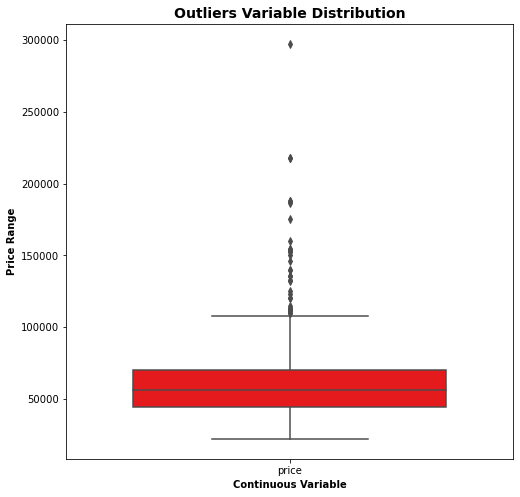

In [1104]:
outliers = ['price']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=ev_df[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Price Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')
ev_df.shape

There are some prices above 17000 that can be termed as outliers but let us keep them as we will standardize later.

In [1105]:
# Segregation of Numerical and Categorical Variables

cat_col = ev_df.select_dtypes(include=['object']).columns
num_col = ev_df.select_dtypes(exclude=['object']).columns
df_cat = ev_df[cat_col]
df_num = ev_df[num_col]

### Visualizing the data

Text(0, 0.5, 'Count of Cars')

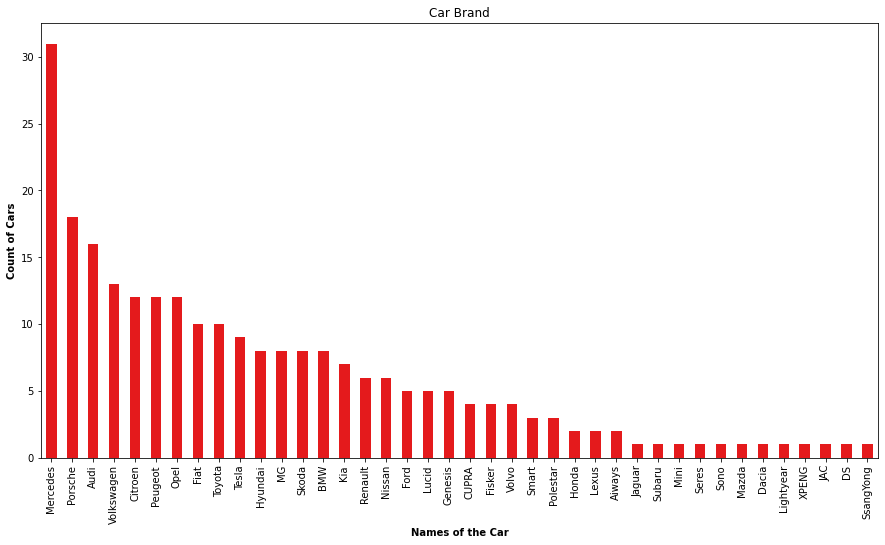

In [1106]:
# Visualizing the different car names available

plt.rcParams['figure.figsize'] = [15,8]
ax=ev_df['brand'].value_counts().plot(kind='bar',stacked=True, colormap = 'Set1')
ax.title.set_text('Car Brand')
plt.xlabel("Names of the Car",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')



* Mercedes has the most number of electric cars.
* There are a lot of companies like Jaguar, Subaru which are quite new to the market.


##### Visualizing the car price distribution

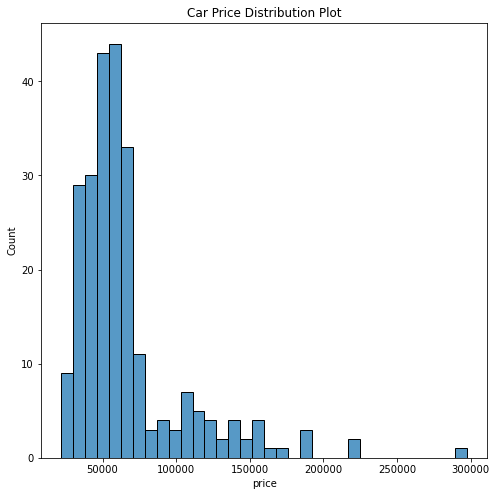

In [1107]:
plt.figure(figsize=(8,8))

plt.title('Car Price Distribution Plot')
sns.histplot(ev_df['price'])
plt.show()

The plot above seems to be right skewed. Most of the prices are below 100,000 euros.

##### Visualizing numerical variables

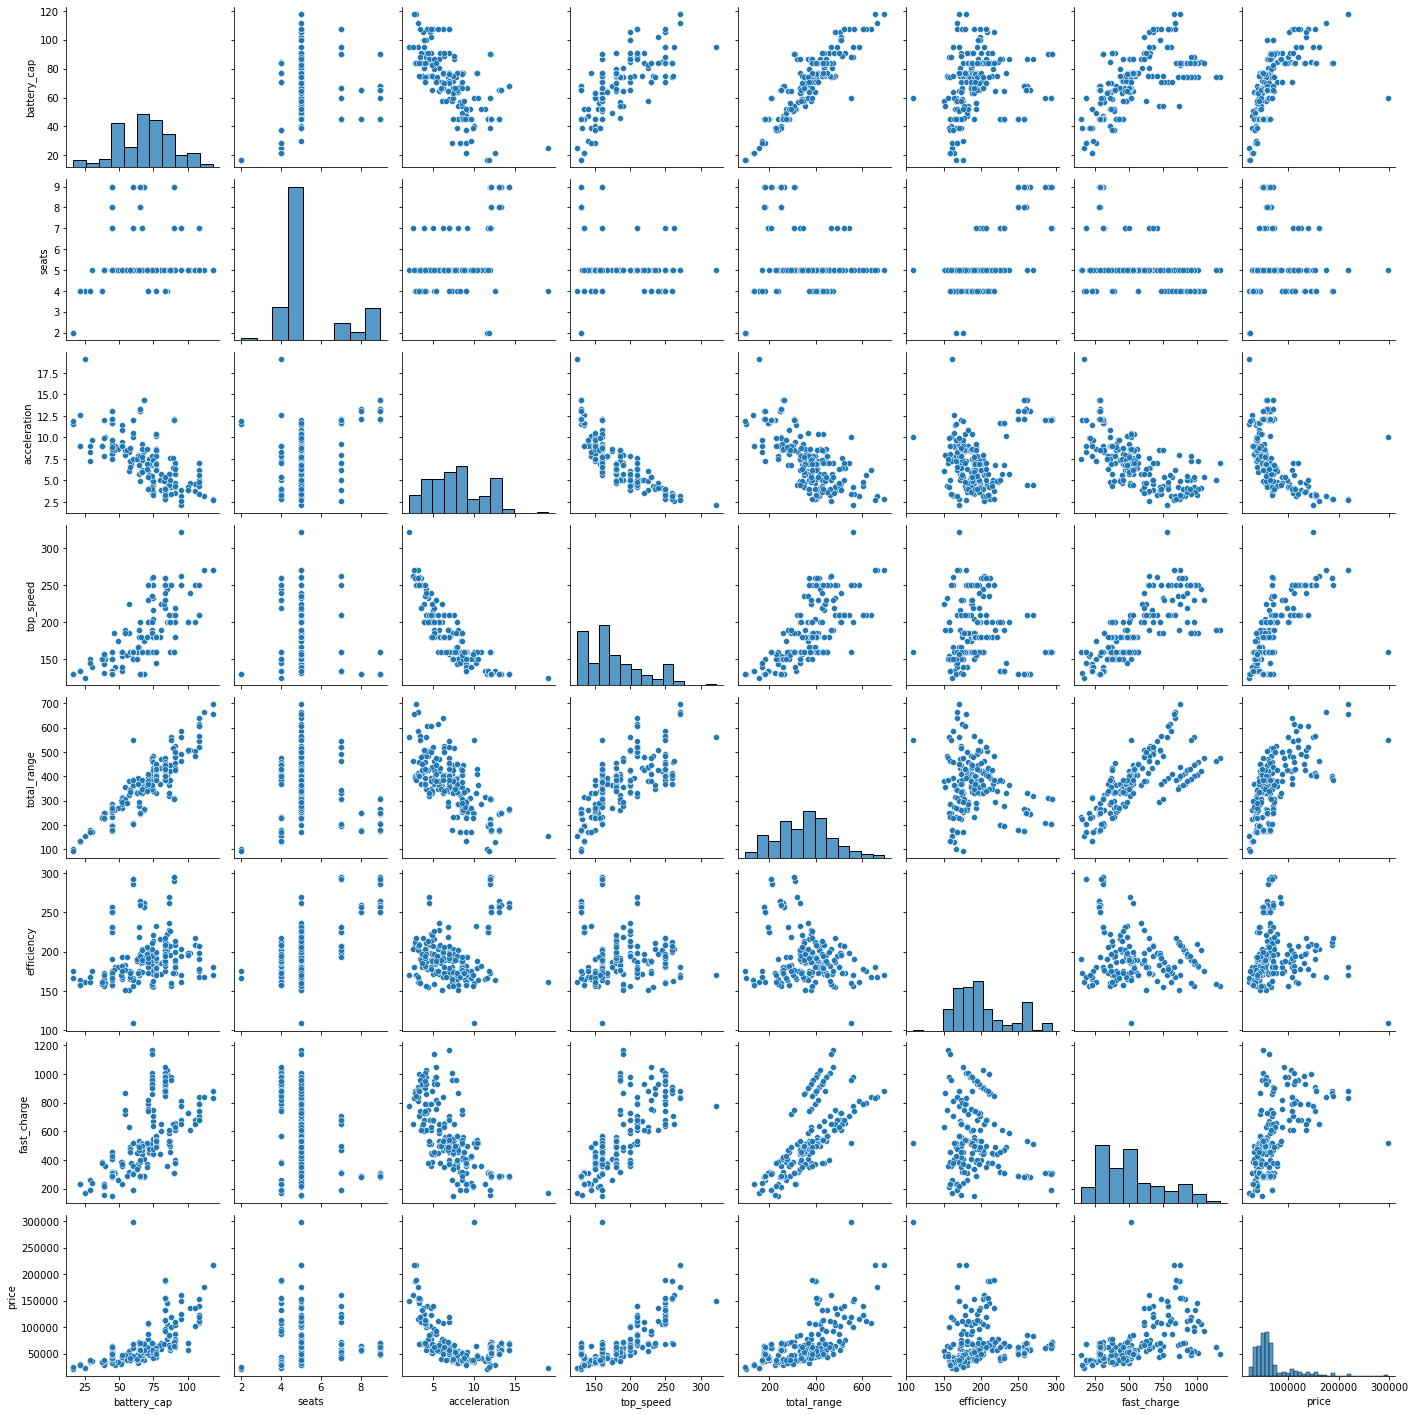

In [1108]:
ax = sns.pairplot(ev_df[num_col])

* battery_cap, top_speed, total_range have a positive correlation with the price.

* seats, efficiency and fast_charge do not show any significant trend.

* acceleration shows a negative correlation with the price.

##### Visualizing categorical variables

In [1109]:
cat_col

Index(['brand', 'model', 'drive', 'shape', 'plug_type', 'market_segment'], dtype='object')

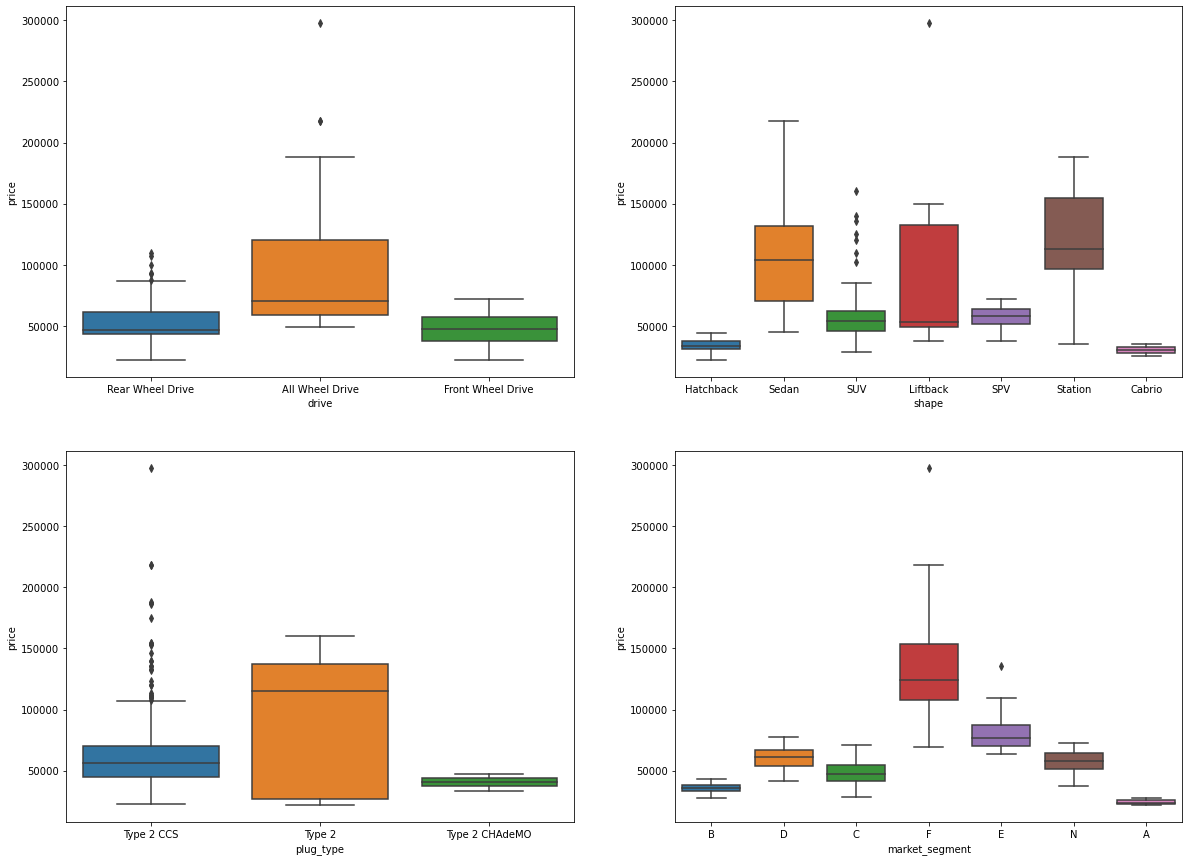

In [1110]:
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
sns.boxplot(x = 'drive', y = 'price', data = ev_df)
plt.subplot(2,2,2)
sns.boxplot(x = 'shape', y = 'price', data = ev_df)
plt.subplot(2,2,3)
sns.boxplot(x = 'plug_type', y = 'price', data = ev_df)
plt.subplot(2,2,4)
sns.boxplot(x = 'market_segment', y = 'price', data = ev_df)
plt.show()

* All wheel drive cars are more expensive than rear wheel or front wheel drive electric cars.

* Sedan body type are usually more expensive than other body types.

* Most of the cars have Type 2 plug type.

* The costlier cars have F market segment.

[Text(0.5, 0, 'Car Body'), Text(0, 0.5, 'Frequency of Car Body')]

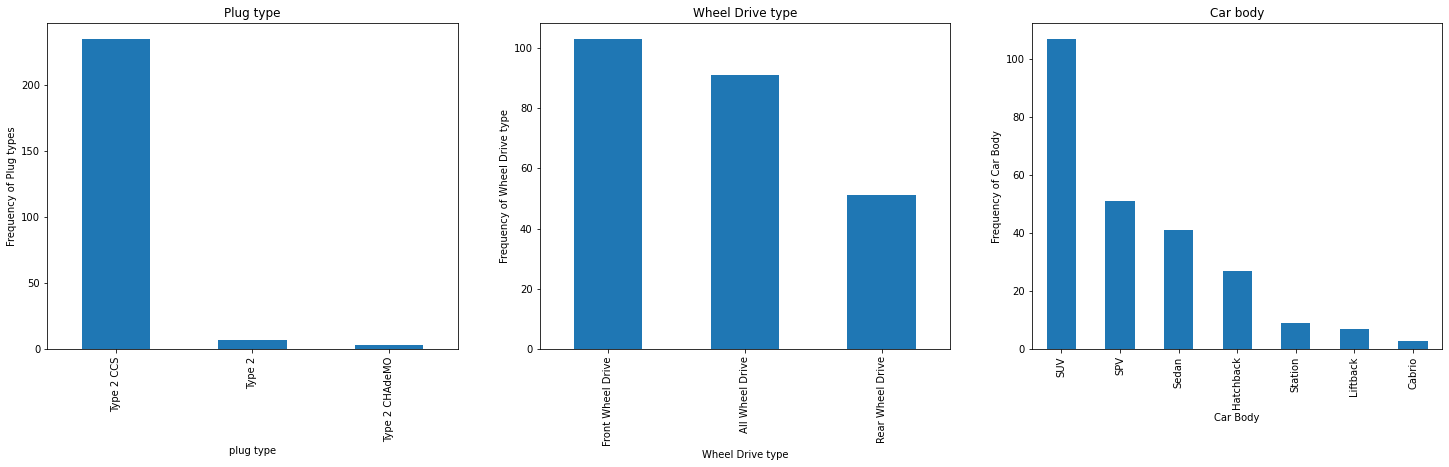

In [1111]:


plt.figure(figsize=(25, 6))

plt.subplot(1,3,1)
plt1 = ev_df['plug_type'].value_counts().plot(kind='bar')
plt.title('Plug type')
plt1.set(xlabel = 'plug type', ylabel='Frequency of Plug types')

plt.subplot(1,3,2)
plt1 = ev_df['drive'].value_counts().plot(kind='bar')
plt.title('Wheel Drive type')
plt1.set(xlabel = 'Wheel Drive type', ylabel='Frequency of Wheel Drive type')

plt.subplot(1,3,3)
plt1 = ev_df['shape'].value_counts().plot(kind='bar')
plt.title('Car body')
plt1.set(xlabel = 'Car Body', ylabel='Frequency of Car Body')



* Most of the cars have Type 2 CCS plug type.

* Number of Front Wheel Drive and All Wheel Drive cars are much more than the Real Wheel Drives.

* SUV is the most preferred car body.

<Figure size 1440x432 with 0 Axes>

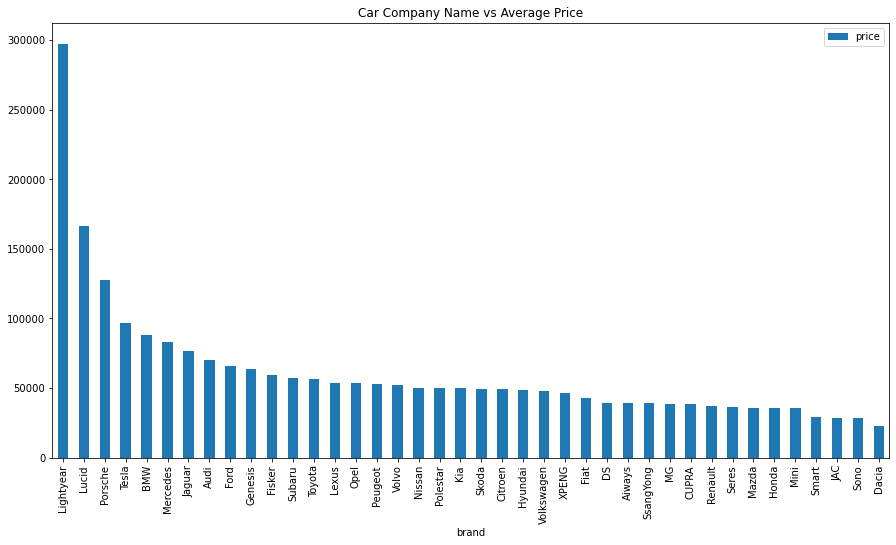

In [1112]:


plt.figure(figsize=(20, 6))

ev_autox = pd.DataFrame(ev_df.groupby(['brand'])['price'].mean().sort_values(ascending = False))
ev_autox.plot.bar()
plt.title('Car Company Name vs Average Price')
plt.show()



Lightyear, Lucid and Porsche seem to have the highest average prices.

<Figure size 1440x432 with 0 Axes>

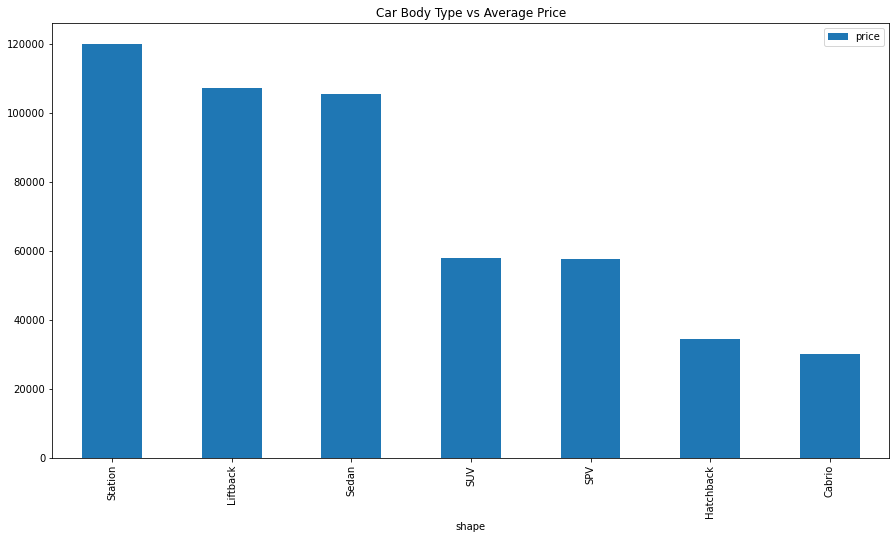

In [1113]:
plt.figure(figsize=(20, 6))

ev_autoy = pd.DataFrame(ev_df.groupby(['shape'])['price'].mean().sort_values(ascending = False))
ev_autoy.plot.bar()
plt.title('Car Body Type vs Average Price')
plt.show()

Station, Liftback and Sedan have higher average prices.

In [1114]:
#Binning the Car Companies based on avg prices of each car Company.

ev_df['price'] = ev_df['price'].astype('int')
ev_auto_temp = ev_df.copy()
t = ev_auto_temp.groupby(['brand'])['price'].mean()
ev_auto_temp = ev_auto_temp.merge(t.reset_index(), how='left',on='brand')
bins = [0,30000,60000,300000]
label =['Budget_Friendly','Medium_Range','TopNotch_Cars']
ev_df['Cars_Category'] = pd.cut(ev_auto_temp['price_y'],bins,right=False,labels=label)
ev_df.head()

,brand,model,drive,shape,plug_type,battery_cap,seats,market_segment,acceleration,top_speed,total_range,efficiency,fast_charge,price,Cars_Category
0,Honda,e,Rear Wheel Drive,Hatchback,Type 2 CCS,28.5,4.0,B,9.0,145.0,170.0,168.0,190.0,33850,Medium_Range
1,Tesla,Model 3 Long Range Dual Motor,All Wheel Drive,Sedan,Type 2 CCS,75.0,5.0,D,4.4,233.0,485.0,155.0,750.0,65365,TopNotch_Cars
2,Tesla,Model 3,Rear Wheel Drive,Sedan,Type 2 CCS,57.5,5.0,D,6.1,225.0,380.0,151.0,630.0,55865,TopNotch_Cars
3,Tesla,Model Y Long Range Dual Motor,All Wheel Drive,SUV,Type 2 CCS,75.0,5.0,D,5.0,217.0,435.0,172.0,670.0,62165,TopNotch_Cars
4,BMW,i4 eDrive40,Rear Wheel Drive,Sedan,Type 2 CCS,80.7,5.0,D,5.7,190.0,470.0,172.0,650.0,59200,TopNotch_Cars


**Significant variables after visualization**

drive, shape, plug_type, market_segment, battery_cap, top_speed, total_range, acceleration, Cars_Category

In [1115]:
sig_col = ['drive', 'shape', 'plug_type', 'market_segment', 'battery_cap', 'top_speed', 'total_range', 'acceleration', 'Cars_Category', 'price']

In [1116]:
df_auto = ev_df[sig_col]

#### Data Preparation

In [1117]:
sig_cat_col = ['drive', 'shape', 'plug_type', 'market_segment', 'Cars_Category']

In [1118]:
# One-Hot Encoding the categorical variables

# One-Hot encode the string categorical data
encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(encoder.fit_transform(df_auto[sig_cat_col]))

# One-Hot encoder removes index, put it back
OH_cols.index = df_auto.index

# Get the feature names 
OH_cols.columns = encoder.get_feature_names_out(sig_cat_col)

# Remove categorical columns that are One-Hot encoded
num_col = df_auto.drop(sig_cat_col, axis=1)

# Add One-Hot encoded columns to numerical columns
df_auto = pd.concat([num_col, OH_cols], axis=1)

df_auto.head()

,battery_cap,top_speed,total_range,acceleration,price,drive_All Wheel Drive,drive_Front Wheel Drive,drive_Rear Wheel Drive,shape_Cabrio,shape_Hatchback,...,market_segment_A,market_segment_B,market_segment_C,market_segment_D,market_segment_E,market_segment_F,market_segment_N,Cars_Category_Budget_Friendly,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
0,28.5,145.0,170.0,9.0,33850,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,75.0,233.0,485.0,4.4,65365,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,57.5,225.0,380.0,6.1,55865,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,75.0,217.0,435.0,5.0,62165,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,80.7,190.0,470.0,5.7,59200,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


##### Splitting the data + Standardization

In [1119]:
# We divide the dataframe into 70/30 ratio

df_train, df_test = train_test_split(df_auto, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1120]:
df_train.head()

,battery_cap,top_speed,total_range,acceleration,price,drive_All Wheel Drive,drive_Front Wheel Drive,drive_Rear Wheel Drive,shape_Cabrio,shape_Hatchback,...,market_segment_A,market_segment_B,market_segment_C,market_segment_D,market_segment_E,market_segment_F,market_segment_N,Cars_Category_Budget_Friendly,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
189,21.3,135.0,135.0,9.0,30395,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145,63.0,150.0,330.0,7.5,39657,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
74,45.0,150.0,265.0,9.7,36140,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
235,65.0,130.0,250.0,13.3,69250,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
198,90.0,160.0,305.0,12.1,72281,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [1121]:
# standardization

scaler = preprocessing.StandardScaler()

sig_num_col = ['battery_cap', 'top_speed', 'total_range', 'acceleration', 'price']
# Apply scaler() to all the columns except the categorical variables

df_train[sig_num_col] = scaler.fit_transform(df_train[sig_num_col])

In [1122]:
df_train.head()

,battery_cap,top_speed,total_range,acceleration,price,drive_All Wheel Drive,drive_Front Wheel Drive,drive_Rear Wheel Drive,shape_Cabrio,shape_Hatchback,...,market_segment_A,market_segment_B,market_segment_C,market_segment_D,market_segment_E,market_segment_F,market_segment_N,Cars_Category_Budget_Friendly,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
189,-2.385613,-1.041850,-1.815171,0.311860,-0.948478,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145,-0.281166,-0.664826,-0.171536,-0.151862,-0.711950,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
74,-1.189560,-0.664826,-0.719414,0.528264,-0.801765,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
235,-0.180233,-1.167525,-0.845848,1.641197,0.043777,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
198,1.081426,-0.413477,-0.382258,1.270219,0.121180,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


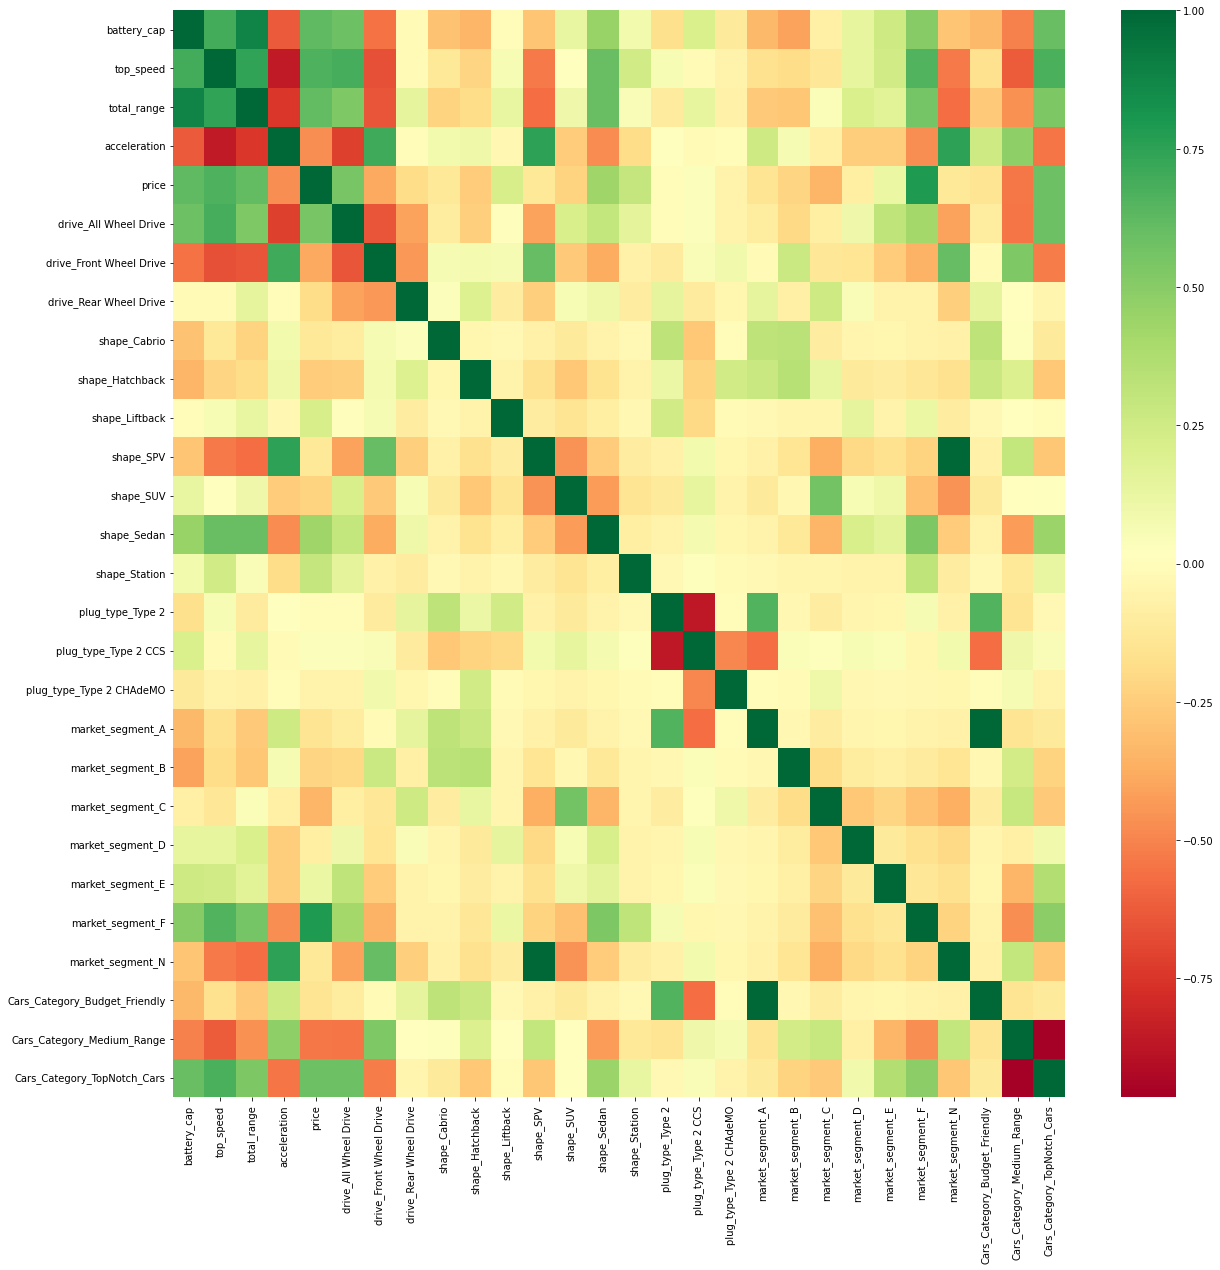

In [1123]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (20, 20))
sns.heatmap(df_train.corr(), cmap="RdYlGn")
plt.show()



In [1124]:
# convert the training set to X and y

y_train = df_train.pop('price')
X_train = df_train

## Building ML models

In [1125]:
# Function to give best model score and parameters

def best_model(model):
    print(f'Best Score: {model.best_score_}')
    print(f'Best Hyperparameters: {model.best_params_}')
    print(f'Best Estimator: {model.best_estimator_}')

### Linear Regression model

In [1126]:
lm = LinearRegression()

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   


array([0.72624206, 0.61675307, 0.39390254, 0.70713116, 0.49739351])

In [1127]:
# Cross-validation using RFE

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 28))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  



Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27]}],
             return_train_score=True, scoring='r2', verbose=1)

In [1128]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008288,0.002917,0.000891,0.000194,1,{'n_features_to_select': 1},0.704209,0.312843,0.398553,0.746969,...,0.532607,0.168937,25,0.592137,0.657799,0.616696,0.568845,0.670428,0.621181,0.038390
1,0.007187,0.001933,0.001010,0.000232,2,{'n_features_to_select': 2},0.675680,0.339934,0.404675,0.664527,...,0.516727,0.135087,26,0.618280,0.672535,0.683783,0.607728,0.674721,0.651410,0.031760
2,0.007020,0.000756,0.001028,0.000222,3,{'n_features_to_select': 3},0.698343,0.356657,0.478326,0.629346,...,0.512125,0.131732,27,0.682050,0.678809,0.693014,0.619018,0.806179,0.695814,0.060934
3,0.008655,0.003625,0.001077,0.000397,4,{'n_features_to_select': 4},0.639103,0.392180,0.614394,0.709338,...,0.550593,0.130766,22,0.697192,0.746173,0.705216,0.682772,0.806179,0.727506,0.044620
4,0.010456,0.002501,0.001105,0.000412,5,{'n_features_to_select': 5},0.679291,0.419653,0.507054,0.744210,...,0.550462,0.137943,23,0.725526,0.770250,0.718050,0.707013,0.808754,0.745918,0.038070
5,0.010598,0.004668,0.001336,0.000857,6,{'n_features_to_select': 6},0.674887,0.429602,0.461615,0.807131,...,0.554323,0.159320,21,0.763558,0.773542,0.782156,0.755737,0.809218,0.776842,0.018489
6,0.007731,0.002105,0.001176,0.000425,7,{'n_features_to_select': 7},0.674887,0.437624,0.384665,0.778220,...,0.545618,0.152982,24,0.763558,0.774346,0.794858,0.764236,0.835251,0.786450,0.026893
7,0.005686,0.000897,0.000799,0.000043,8,{'n_features_to_select': 8},0.742721,0.560502,0.466513,0.798142,...,0.611773,0.134313,5,0.799462,0.816360,0.802708,0.779646,0.843476,0.808330,0.021132
8,0.005882,0.001159,0.000921,0.000292,9,{'n_features_to_select': 9},0.742608,0.605051,0.463514,0.799517,...,0.616853,0.136646,3,0.805092,0.821170,0.804318,0.786437,0.847158,0.812835,0.020381
9,0.005097,0.000727,0.000825,0.000200,10,{'n_features_to_select': 10},0.732323,0.620737,0.490048,0.799778,...,0.632572,0.119197,1,0.818826,0.822468,0.805649,0.788280,0.858951,0.818835,0.023366


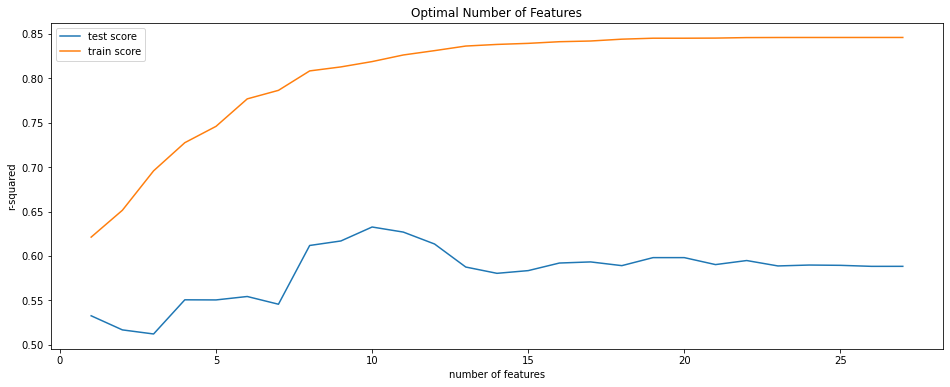

In [1129]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')



### Random Forest Regressor

In [1130]:
random_forest = RandomForestRegressor()

hyper_params = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]} 
random_forest_cv = GridSearchCV(random_forest, hyper_params, cv=5, refit=True, verbose=0)

random_forest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 6, 7, 8],
                         'max_features': [2, 4, 6, 7, 8, 9],
                         'min_samples_split': [3, 5, 6, 7],
                         'n_estimators': [50, 100]})

In [1131]:
best_model(random_forest_cv)

Best Score: 0.8227612783817099
Best Hyperparameters: {'max_depth': 6, 'max_features': 9, 'min_samples_split': 3, 'n_estimators': 50}
Best Estimator: RandomForestRegressor(max_depth=6, max_features=9, min_samples_split=3,
                      n_estimators=50)


### XGBoost Regressor

In [1132]:
xg_boost = XGBRegressor()

hyper_params  = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001], 'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xg_boost_cv = GridSearchCV(xg_boost, hyper_params, cv=5, refit=True, verbose=0)

xg_boost_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...0, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                  

In [1133]:
best_model(xg_boost_cv)

Best Score: 0.8310923575124705
Best Hyperparameters: {'gamma': 0.01, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 20}
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


#### Best models

In [1134]:
# Linear Regressor

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=12)             
rfe = rfe.fit(X_train, y_train)

In [1135]:
# Random Forest Regressor

random_forest = RandomForestRegressor(max_depth=8, max_features=8, min_samples_split=3)

random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=8, min_samples_split=3)

In [1136]:
# XGBoost Regressor

xg_boost = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, gamma=0.001, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.1, max_delta_step=0, max_depth=5, min_child_weight=1, missing=np.nan, monotone_constraints='()', n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',validate_parameters=1, verbosity=None)

xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.001, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### R2 scores

In [1137]:
r2_score(y_train, lm.predict(X_train))

0.8301297394564684

In [1138]:
r2_score(y_train, random_forest.predict(X_train))

0.9670841924005478

In [1139]:
r2_score(y_train, xg_boost.predict(X_train))

0.995808250615794

#### Performance on the Test set

In [1140]:
# Standardizing the test set
scaler = preprocessing.StandardScaler()
df_test[sig_num_col] = scaler.fit_transform(df_test[sig_num_col])

df_test.head()

,battery_cap,top_speed,total_range,acceleration,price,drive_All Wheel Drive,drive_Front Wheel Drive,drive_Rear Wheel Drive,shape_Cabrio,shape_Hatchback,...,market_segment_A,market_segment_B,market_segment_C,market_segment_D,market_segment_E,market_segment_F,market_segment_N,Cars_Category_Budget_Friendly,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
65,0.239168,-0.431001,0.130391,-0.292749,-0.201643,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
59,1.370485,1.770276,1.336507,-1.252724,1.722248,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
191,-0.067630,-1.164759,-0.807700,1.755198,-0.044905,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
111,0.488441,0.058172,0.398417,-0.516743,-0.189959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112,-1.745432,-0.920173,-1.522435,0.603228,-0.814347,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1141]:
y_test = df_test.pop('price')
X_test = df_test

In [1142]:
r2_score(y_test, xg_boost.predict(X_test))

0.9456989243638133